In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm,trange

from shutil import rmtree

from scipy.signal import savgol_filter

from numpy.linalg import inv
from scipy.signal import butter,filtfilt

In [2]:
def get_angle(dx,dy,scale=5):
    dx = dx*scale
    dy = dy*scale

    angle = np.degrees(np.pi*2 + math.atan2(dy, dx))%360
    return angle

def get_xy(center,depth,P,c=0):
    
    center = np.array(center).reshape((1,2))
    depth = np.array(depth).reshape(1,1)

    return imagetocamera(center,depth,P)

def imagetocamera(points, depth, projection):
    """
    points: (N, 2), N points on X-Y image plane
    depths: (N,), N depth values for points
    projection: (3, 4), projection matrix
    corners: (N, 3), N points on X(right)-Y(down)-Z(front) camera coordinate
    """
    assert points.shape[1] == 2, "Shape ({}) not fit".format(points.shape)

    corners = np.hstack([points, np.ones(
        (points.shape[0], 1))]).dot(inv(projection[:, 0:3]).T)
    assert np.allclose(corners[:, 2], 1)
    corners *= depth.reshape(-1, 1)

    return list(corners[0])

def read_calib(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
        
    return P2

In [3]:
def smoothing(df,columns,window_size=17,order=3):
#     if len(df) < window_size:
#         window_size = len(df)
    
#     if window_size <= order:
#         return df
    
#     print(window_size,order)
    for col in columns:
        df[col] = savgol_filter(df[col], len(df), order, mode='interp')
        
    return df

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [4]:
BASE_DIR_calib = '/home/alfin/Documents/deep_learning/production/centernet_3d_fish/'
# BASE_DIR = BASE_DIR_calib
BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'
# BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/general_eval/KITTI/detection/training/'

IMG_DIR = os.path.join(BASE_DIR,'output_3_pad/')
# IMG_DIR = os.path.join(BASE_DIR,'image_2/')
INF_DIR = os.path.join(BASE_DIR,'association_inference/')
CALIB_DIR = os.path.join(BASE_DIR_calib,'data/')

data_path = [{'img':IMG_DIR+img,'inf':INF_DIR+inf
             } for img,inf in 
             zip(sorted(os.listdir(IMG_DIR)),
                 sorted([x for x in os.listdir(INF_DIR) if not x.endswith('angle.txt')])
                
#                  sorted([x for x in os.listdir(INF_DIR) if x.endswith('track.txt')])
                )]
calib_path = os.path.join(CALIB_DIR,'000000.txt')

In [5]:
len(data_path)

300

In [6]:
data_path

[{'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000000.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000000.txt'},
 {'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000001.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000001.txt'},
 {'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000002.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000002.txt'},
 {'img': '/home/alfin/Documents/deep_lea

In [7]:
img_input_size = (512,512)

inf_header = ['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id']

all_data = []
for j,data in tqdm(enumerate(data_path[:])):

    ann = pd.read_csv(data['inf'],sep = ' ',names=inf_header)
    for i in range(len(ann)):
        label = ann.iloc[i]

        label_dict = label.to_dict()
        label_dict['filename'] = data['inf']
        all_data.append(label_dict)


300it [00:00, 469.42it/s]


In [8]:
df_input = pd.DataFrame(all_data)
df_input = df_input.drop_duplicates(keep=False)
df_output = []

In [9]:
len(df_input['filename'].unique())

300

In [59]:
window_size = 5
order = 4

df_num = df_input['id'].value_counts()
# df_filtered = df_input[df_input['id'].isin(df_num[df_num >= window_size].index)]

smooth_columns=['alphax', 'alphay','w','h','l','z']

In [60]:
for fish_id in df_input['id'].unique():
    tmp = df_input[df_input['id']==fish_id].sort_values('idx')
    
    if len(tmp) < 15:
        continue
    
    if len(tmp) > window_size :
        tmp = smoothing(tmp,smooth_columns,window_size=window_size,order=order)
        
        if len(df_output) == 0:
            df_output = tmp
        else:
            df_output =  pd.concat([df_output,tmp])
    
# df_output = df.reset_index(drop=True)

In [61]:
df_output = df_output.reset_index(drop=True)
len(df_output['filename'].unique())

300

In [62]:
filenames = list(df_output['filename'].unique())
for filename in filenames:
    df_file = df_output[df_output['filename']==filename]
#     df_file = df_file[inf_header+['angle','rx','ry','rz']]
    df_file = df_file[inf_header]
    
    save_path = os.path.splitext(filename)[0]+'_angle.txt'
    df_file.to_csv(save_path,header=False,sep=' ',index=False)

In [64]:
d = df_input.copy()

In [152]:
d_1 = d[d['id']==44]
d_pass = d_1['alphax']

In [156]:
fs = 30.0       # sample rate, Hz
cutoff = 1
order = 2

res = butter_lowpass_filter(d_pass.values,cutoff,fs,order)

In [161]:
d_1['lowpass'] = res

/tmp/ipykernel_4419/1539377616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_1['lowpass'] = res


In [159]:
col_sample = 'alphax'
d_1['savgol'] = smoothing(d_1.copy(),[col_sample],window_size=5,order=4)[col_sample].values

/tmp/ipykernel_4419/2965848718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_1['savgol'] = smoothing(d_1.copy(),[col_sample],window_size=5,order=4)[col_sample].values


<AxesSubplot: >

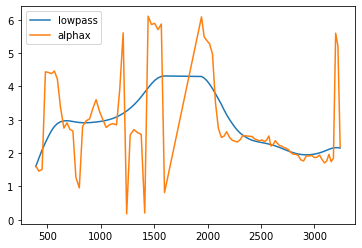

In [164]:
d_1[['lowpass','alphax']].plot()

<AxesSubplot: >

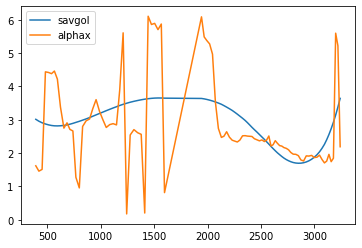

In [165]:
d_1[['savgol','alphax']].plot()

<AxesSubplot: >

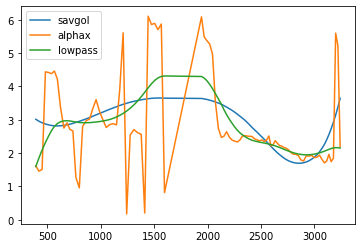

In [166]:
d_1[['savgol','alphax','lowpass']].plot()

<AxesSubplot: >

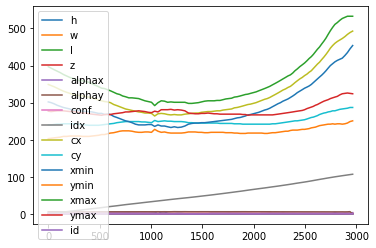

In [27]:
d_1.plot()